# David Fleming, Feb. 9th, 2016
This notebook copies the stellar and gaseous disk properties from a previous tipsy snapshot generated by ICgen (see diskpy) and inserts a planet of user-specified mass and semimajor axis along the x-axis.  The planet is assumed to feel the gravity of the binary and the gas particles with a cylindrical radius less than its own for its initial keplerian velocity computation.

In [16]:
%matplotlib inline
#Imports required to run

import pynbody
SimArray = pynbody.array.SimArray
import matplotlib as mpl
import matplotlib.pyplot as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate

#Tell code where my diskpy distribution is
import os

#Import diskpy and my modules from ICgen submodule
import diskpy
from diskpy.ICgen import *
from diskplot import *

from __future__ import division

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

# Load initial planet-less ICs, subtract off center of mass

In [17]:
#Change directory to where the data is
cwd = '/astro/users/dflemin3/Desktop/sims/k38_2016_sims/k38_e_0.1032_final'
os.chdir(cwd)

In [18]:
#Load Snapshot 
s = pynbody.load('k38_snap.std')

#Center on barycenter
diskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
s['pos'] -= diskCom

# Make a new pynbody snapshot object with a dark matter (dm) particle to act as our planet.
The dark matter particle is nice because it won't interact with any SPH stuff as expected for a planet decoupled from the disk AND dark matter particles don't accrete like stars so we don't have to do anything funny with the stellar sink radius.

In [19]:
s2 = pynbody.new(star=3, gas=100000, dm=0)

# Copy all the properties from the old snapshot into the new one for both the gas and star keys

In [20]:
# Copy star properties
s2.star[0]['pos'] = s.star[0]['pos']
s2.star[0]['vel'] = s.star[0]['vel']
s2.star[1]['pos'] = s.star[1]['pos']
s2.star[1]['vel'] = s.star[1]['vel']
s2.star[0]['mass'] = s.star[0]['mass']
s2.star[1]['mass'] = s.star[1]['mass']
s2.star[0]['metals'] = s.star[0]['metals']
s2.star[1]['metals'] = s.star[1]['metals']
s2.star[0]['eps'] = s.star[0]['eps'] 
s2.star[1]['eps'] = s.star[1]['eps']

# Make sure stars are sinks
s2.star['tform'] = -1.0

#Assign gas particles with calculated/given values from above
s2.gas['pos'] = s.gas['pos']
s2.gas['vel'] = s.gas['vel']
s2.gas['temp'] = s.gas['temp']
s2.gas['rho'] = s.gas['rho']
s2.gas['eps'] = s.gas['eps']
s2.gas['mass'] = s.gas['mass']
s2.gas['metals'] = s.gas['metals']

# Generate a Binary object with the "planet" as the secondary to get its position, velocity subject to whatever orbital elements I want.  Allows me to arbitrarily change the orbit.

In [21]:
# X = [e, a, i, Omega, w, nu]
X = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

# Find gas mass interior to orbit where a_planet = X[1]
gas_mask = s2.gas['rxy'].in_units('au') < X[1]
m_gas = np.sum(s.gas['mass'][gas_mask])

# m1 = mass of primary = mass of binary + mass of gas interior to a_planet
m1 = m_gas + s.stars[0]['mass'] + s.stars[1]['mass']

# m2 = mass of planet in solar masses
#m2 = 3.0e-5 * (s2.stars[0]['mass']+s2.stars[1]['mass']) # Pierens+Nelson suggestion
m2 = 3.003467e-5 # 10 earth masses
m2 *= 0.5

# Make planet Binary object, generate the positions, velocities
planet = binary.Binary(X,m1=m1,m2=m2,state='Kepler')
r1, r2, v1, v2 = planet.generateICs()

# Note: I'm going to assume, rather safely, that the planet does not change the binary's positions, velocities, etc. 
This assumption will suffice for m_planet < m_jup probs

In [22]:
r_unit = s2['pos'].units
v_unit = s2['vel'].units
m_unit = s2['mass'].units

s2.star[2]['pos'] = SimArray(r2,r_unit)
s2.star[2]['vel'] = SimArray(v2,v_unit)
s2.star[2]['mass'] = SimArray(m2,m_unit)

# For the planet smoothing length, use the gas smoothing length

In [23]:
s2.stars[2]['eps'] = np.mean(s2.gas['eps']).in_units(s2.gas['eps'].units)

# For the planet sink radius, use the hill radius or the bondi radius

# Hill radius

The hill radius is the region in which it dominates the attraction of satellites.

$$
r_H = a_p*(m_p/3M_{bin})^{1/3}
$$

In [24]:
planet

(0.0,1.0,0.0,0.0,0.0,0.0), mass: ([ 1.19875114],1.5017335e-05)

In [25]:
mb = s.stars[0]['mass']+s.stars[1]['mass']
rh = planet.a*np.power((m2/(3.*mb)),1./3.)
print(0.25*rh)

[ 0.00402666]


In [26]:
0.5*rh

SimArray([ 0.00805332], 'au Msol**-1')

# Compute the Bondi Radius

$R_b$ is the distance beyond which the
thermal energy of the gas is larger than the gravitational energy
that binds the gas to the planet and is given by
$$
R_b = \frac{Gm_p}{c^2_s}
$$

where $c_s$ is the local sound speed and $m_p$ is the mass of the planet.

/astro/users/dflemin3/.local/lib/python2.7/site-packages/pynbody/analysis/profile.py:418: RuntimeWarning: invalid value encountered in double_scalars
  result[i] = (name_array * mass_array).sum() / self['mass'][i]


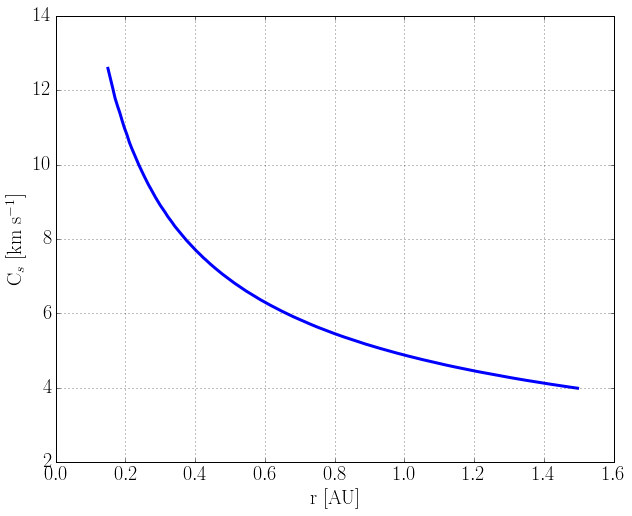

In [27]:
pg = pynbody.analysis.profile.Profile(s.gas,nbins=200,max='1.5 au')
plt.plot(pg['rbins'].in_units('au'),pg['cs'].in_units('km s**-1'),lw=3)

plt.ylabel(r'C$_s$ [km s$^{-1}$]')
plt.xlabel(r'r [AU]')
plt.grid()

In [28]:
cs = SimArray(4.5,'km s**-1')
mp = s2.stars[2]['mass'].in_units('Msol')

r_b = (AddBinary.G*mp/(cs**2)).in_units('au')
print(r_b)

[ 0.00065789]


# Write to a new snapshot!

In [29]:
s2.write(fmt=pynbody.tipsy.TipsySnap, filename="k38_planet.std")

In [30]:
s2.stars['mass']

SimArray([  9.49000001e-01,   2.48999998e-01,   1.50173350e-05], 'Msol')